<a href="https://colab.research.google.com/github/nafishr24/home_credit_project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **STEP 1 - Imports & SETTINGS**

In [29]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import gc
import joblib
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# Paths - adjust as needed
DATA_DIR = Path("/content/drive/MyDrive/file") # put your csvs here
OUT_DIR = Path("/content/drive/MyDrive/file/hasil")
PLOTS_DIR = OUT_DIR / 'plots'
OUT_DIR.mkdir(parents=True, exist_ok=True)


RANDOM_STATE = 35
N_FOLDS = 5
TARGET = 'TARGET'
ID_COL = 'SK_ID_CURR'


print('Settings loaded')

Settings loaded


In [36]:
def save_plot(name, ext='png', dpi=150, close_fig=True):
    """
    Simpan figure matplotlib saat ini ke PLOTS_DIR dengan nama name.ext.
    close_fig=True akan memanggil plt.close() setelah menyimpan supaya notebook tidak menampilkan plot lagi.
    """
    import matplotlib.pyplot as _plt
    fname = PLOTS_DIR / f"{name}.{ext}"
    try:
        _plt.savefig(fname, bbox_inches='tight', dpi=dpi)
        print(f"Saved plot: {fname}")
    except Exception as e:
        print("Failed to save plot", fname, e)
    if close_fig:
        _plt.close()

# **STEP 2 - Helper functions used across cells**

In [2]:
def load_csv_safe(path):
    if not Path(path).exists():
        print(f"WARNING: {path} not found. Skipping and returning empty DataFrame.")
        return pd.DataFrame()
    return pd.read_csv(path)


def df_overview(df, name=None, n=5):
    if name:
        print('-----', name, '-----')
    print('shape:', df.shape)
    print(df.dtypes.value_counts())
    print('\nhead:')
    display(df.head(n))
    print('\nmissing%:')
    print((df.isnull().mean()*100).sort_values(ascending=False).head(10))


def reduce_mem_usage(df, verbose=True):
    # typical memory reducer
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                df[col] = pd.to_numeric(df[col], downcast='float')
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Mem. usage decreased to {end_mem:5.2f} MB ({100*(start_mem-end_mem)/start_mem:.1f}% reduction)')
    return df

# PSI function for monitoring
def psi(expected, actual, buckets=10):
    def _get_bins(x, n):
        return np.linspace(np.min(x), np.max(x), n+1)
    bins = _get_bins(expected, buckets)
    exp_perc = np.histogram(expected, bins=bins)[0] / len(expected)
    act_perc = np.histogram(actual, bins=bins)[0] / len(actual)
    # replace zeros
    act_perc = np.where(act_perc==0, 1e-8, act_perc)
    exp_perc = np.where(exp_perc==0, 1e-8, exp_perc)
    return np.sum((exp_perc - act_perc) * np.log(exp_perc / act_perc))

# **STEP 3 - Load data**

In [3]:

apps = load_csv_safe(DATA_DIR / 'application_train.csv')
apps_test = load_csv_safe(DATA_DIR / 'application_test.csv')
bureau = load_csv_safe(DATA_DIR / 'bureau.csv')
bb = load_csv_safe(DATA_DIR / 'bureau_balance.csv')
previous = load_csv_safe(DATA_DIR / 'previous_application.csv')
pos = load_csv_safe(DATA_DIR / 'POS_CASH_balance.csv')
cc = load_csv_safe(DATA_DIR / 'credit_card_balance.csv')
inst = load_csv_safe(DATA_DIR / 'installments_payments.csv')

# Quick overviews
for df, name in [(apps, 'application_train'), (apps_test, 'application_test'), (bureau, 'bureau'), (bb, 'bureau_balance'), (previous, 'previous_application'), (pos, 'POS_CASH_balance'), (cc, 'credit_card_balance'), (inst, 'installments_payments')]:
    if df.shape[0]>0:
        print('\n')
        df_overview(df, name=name, n=2)

# If train loaded, reduce mem
if apps.shape[0] > 0:
    apps = reduce_mem_usage(apps)
    if apps_test.shape[0] > 0:
        apps_test = reduce_mem_usage(apps_test)




----- application_train -----
shape: (307511, 122)
float64    65
int64      41
object     16
Name: count, dtype: int64

head:


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0



missing%:
COMMONAREA_AVG              69.872297
COMMONAREA_MODE             69.872297
COMMONAREA_MEDI             69.872297
NONLIVINGAPARTMENTS_MEDI    69.432963
NONLIVINGAPARTMENTS_MODE    69.432963
NONLIVINGAPARTMENTS_AVG     69.432963
FONDKAPREMONT_MODE          68.386172
LIVINGAPARTMENTS_AVG        68.354953
LIVINGAPARTMENTS_MEDI       68.354953
LIVINGAPARTMENTS_MODE       68.354953
dtype: float64


----- application_test -----
shape: (48744, 121)
float64    65
int64      40
object     16
Name: count, dtype: int64

head:


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0



missing%:
COMMONAREA_AVG              68.716150
COMMONAREA_MEDI             68.716150
COMMONAREA_MODE             68.716150
NONLIVINGAPARTMENTS_AVG     68.412523
NONLIVINGAPARTMENTS_MEDI    68.412523
NONLIVINGAPARTMENTS_MODE    68.412523
FONDKAPREMONT_MODE          67.284179
LIVINGAPARTMENTS_MEDI       67.249302
LIVINGAPARTMENTS_AVG        67.249302
LIVINGAPARTMENTS_MODE       67.249302
dtype: float64


----- bureau -----
shape: (1716428, 17)
float64    8
int64      6
object     3
Name: count, dtype: int64

head:


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN



missing%:
AMT_ANNUITY               71.473490
AMT_CREDIT_MAX_OVERDUE    65.513264
DAYS_ENDDATE_FACT         36.916958
AMT_CREDIT_SUM_LIMIT      34.477415
AMT_CREDIT_SUM_DEBT       15.011932
DAYS_CREDIT_ENDDATE        6.149573
AMT_CREDIT_SUM             0.000757
SK_ID_CURR                 0.000000
SK_ID_BUREAU               0.000000
CREDIT_DAY_OVERDUE         0.000000
dtype: float64


----- bureau_balance -----
shape: (27299925, 3)
int64     2
object    1
Name: count, dtype: int64

head:


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C



missing%:
SK_ID_BUREAU      0.0
MONTHS_BALANCE    0.0
STATUS            0.0
dtype: float64


----- previous_application -----
shape: (1670214, 37)
object     16
float64    15
int64       6
Name: count, dtype: int64

head:


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0



missing%:
RATE_INTEREST_PRIVILEGED     99.643698
RATE_INTEREST_PRIMARY        99.643698
AMT_DOWN_PAYMENT             53.636480
RATE_DOWN_PAYMENT            53.636480
NAME_TYPE_SUITE              49.119754
DAYS_TERMINATION             40.298129
DAYS_FIRST_DRAWING           40.298129
DAYS_FIRST_DUE               40.298129
DAYS_LAST_DUE_1ST_VERSION    40.298129
DAYS_LAST_DUE                40.298129
dtype: float64


----- POS_CASH_balance -----
shape: (10001358, 8)
int64      5
float64    2
object     1
Name: count, dtype: int64

head:


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0



missing%:
CNT_INSTALMENT_FUTURE    0.260835
CNT_INSTALMENT           0.260675
SK_ID_CURR               0.000000
SK_ID_PREV               0.000000
MONTHS_BALANCE           0.000000
NAME_CONTRACT_STATUS     0.000000
SK_DPD                   0.000000
SK_DPD_DEF               0.000000
dtype: float64


----- credit_card_balance -----
shape: (3840312, 23)
float64    15
int64       7
object      1
Name: count, dtype: int64

head:


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0



missing%:
AMT_PAYMENT_CURRENT           19.998063
CNT_DRAWINGS_POS_CURRENT      19.524872
AMT_DRAWINGS_ATM_CURRENT      19.524872
CNT_DRAWINGS_ATM_CURRENT      19.524872
AMT_DRAWINGS_POS_CURRENT      19.524872
AMT_DRAWINGS_OTHER_CURRENT    19.524872
CNT_DRAWINGS_OTHER_CURRENT    19.524872
CNT_INSTALMENT_MATURE_CUM      7.948208
AMT_INST_MIN_REGULARITY        7.948208
AMT_DRAWINGS_CURRENT           0.000000
dtype: float64


----- installments_payments -----
shape: (13605401, 8)
float64    5
int64      3
Name: count, dtype: int64

head:


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525



missing%:
AMT_PAYMENT               0.021352
DAYS_ENTRY_PAYMENT        0.021352
SK_ID_PREV                0.000000
SK_ID_CURR                0.000000
NUM_INSTALMENT_NUMBER     0.000000
NUM_INSTALMENT_VERSION    0.000000
DAYS_INSTALMENT           0.000000
AMT_INSTALMENT            0.000000
dtype: float64
Mem. usage decreased to 96.49 MB (66.3% reduction)
Mem. usage decreased to 15.25 MB (66.1% reduction)


Variable 'apps' found with shape: (307511, 126)
Columns (first 30): ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']

TARGET column found — plotting distribution


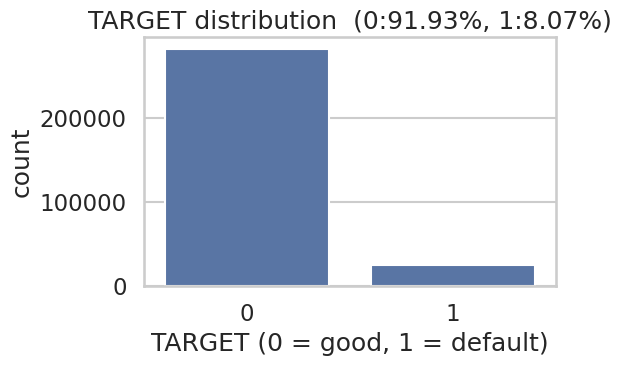

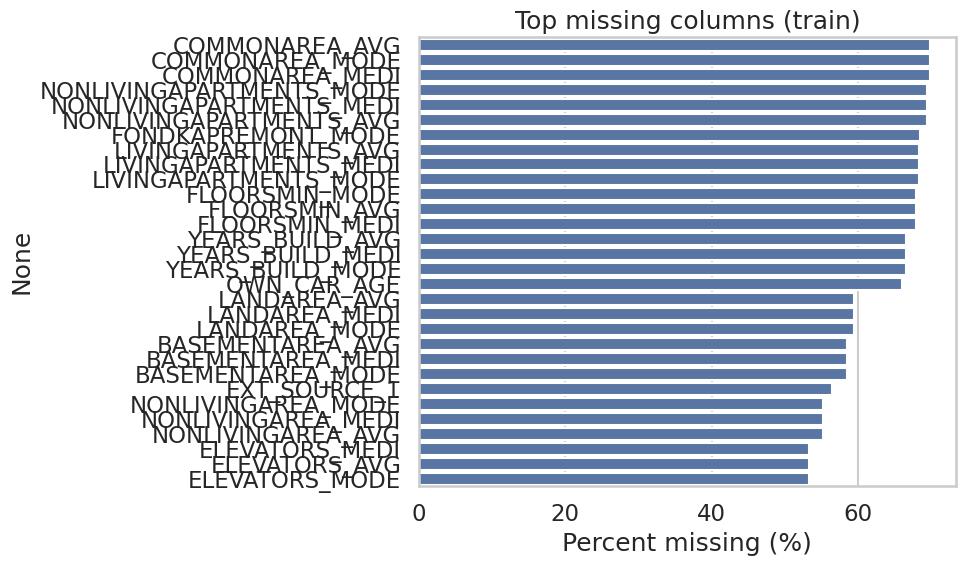

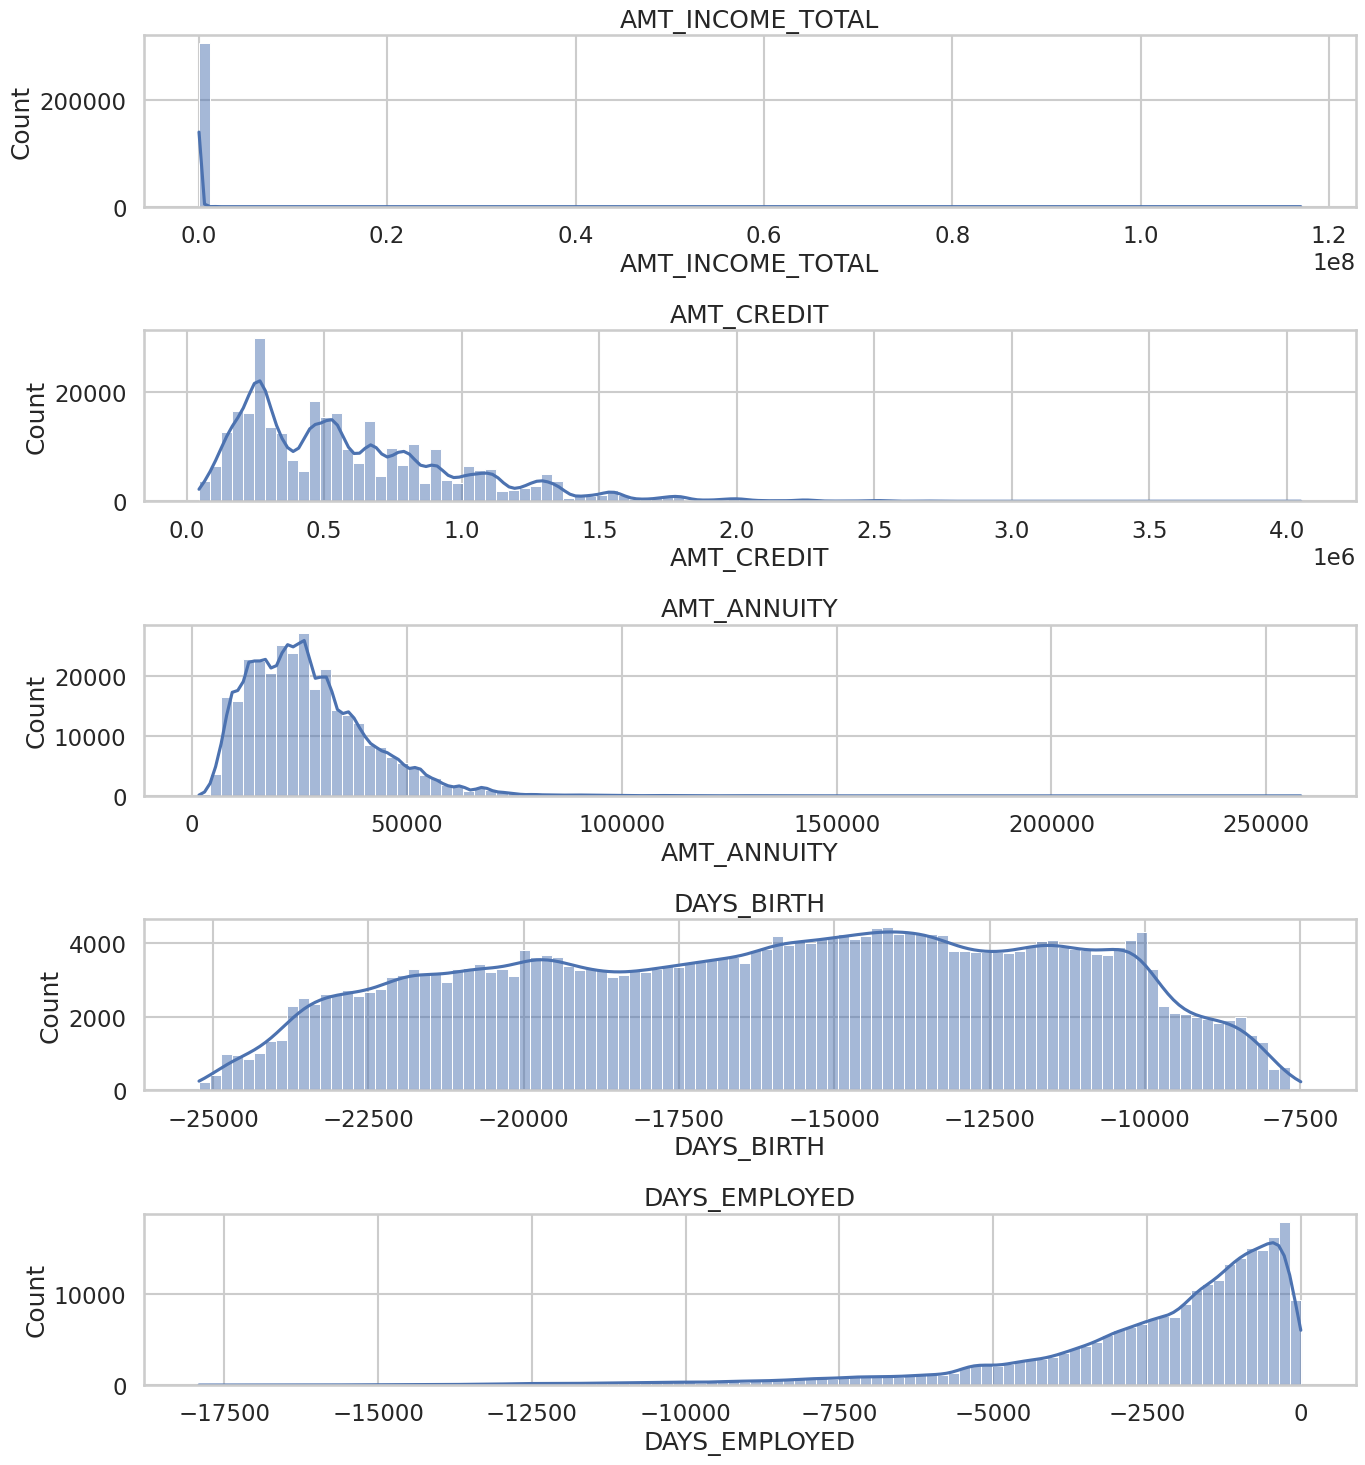

TARGET not in numeric columns after selection.


In [37]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='talk')

# Helper: check existence and print diagnostics
def check_apps():
    if 'apps' in globals():
        print("Variable 'apps' found with shape:", getattr(apps, 'shape', None))
        print("Columns (first 30):", list(apps.columns[:30]))
    else:
        print("Variable 'apps' not found in workspace. Trying to load application_train.csv from DATA_DIR...")
        from pathlib import Path
        p = Path('./data') / 'application_train.csv'
        if p.exists():
            print(f"Loading {p}")
            globals()['apps'] = pd.read_csv(p)
            print("Loaded apps with shape:", apps.shape)
        else:
            print(f"No application_train.csv at {p}. Please set DATA_DIR or ensure you loaded the train file.")

check_apps()

# If TARGET exists, show target distribution; otherwise show a warning and continue
if 'apps' in globals() and 'TARGET' in apps.columns:
    print("\nTARGET column found — plotting distribution")
    plt.figure(figsize=(6,4))
    sns.countplot(x=apps['TARGET'])
    pct = apps['TARGET'].value_counts(normalize=True).sort_index().values * 100
    plt.title(f'TARGET distribution  (0:{pct[0]:.2f}%, 1:{pct[1]:.2f}%)')
    plt.xlabel('TARGET (0 = good, 1 = default)')
    plt.tight_layout()
    plt.show()
else:
    print("\nTARGET column NOT found. Skipping TARGET distribution plot.")
    # If you have merged df with target, try to find it there
    if 'df' in globals() and 'TARGET' in df.columns:
        print("Found TARGET in 'df' (merged). Plotting using df instead.")
        plt.figure(figsize=(6,4))
        sns.countplot(x=df['TARGET'])
        pct = df['TARGET'].value_counts(normalize=True).sort_index().values * 100
        plt.title(f'TARGET distribution from df  (0:{pct[0]:.2f}%, 1:{pct[1]:.2f}%)')
        plt.tight_layout()
        plt.show()
    else:
        print("No TARGET found in 'apps' or 'df'. If this is unexpected, reload 'application_train.csv' (not test) into 'apps'.")

# Top missing% safe plot (works even without TARGET)
if 'apps' in globals():
    miss = apps.isnull().mean().sort_values(ascending=False) * 100
    miss_top = miss[miss>0].head(30)
    if len(miss_top) > 0:
        plt.figure(figsize=(10,6))
        sns.barplot(x=miss_top.values, y=miss_top.index)
        plt.xlabel('Percent missing (%)')
        plt.title('Top missing columns (train)')
        plt.tight_layout()
        plt.show()
    else:
        print("No missing values in 'apps' (or none > 0%).")
else:
    print("'apps' not available for missingness plot.")

# Numeric distributions (safe selection)
if 'apps' in globals():
    num_cols = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','DAYS_BIRTH','DAYS_EMPLOYED']
    present = [c for c in num_cols if c in apps.columns]
    if len(present) > 0:
        plt.figure(figsize=(14,3*len(present)))
        for i,c in enumerate(present,1):
            plt.subplot(len(present),1,i)
            sns.histplot(apps[c].dropna(), bins=100, kde=True)
            plt.title(c)
        plt.tight_layout()
        plt.show()
    else:
        print("None of key numeric columns found in 'apps' for distribution plots.")
else:
    print("'apps' not available for numeric distributions.")

# Correlation with target (safe)
if 'apps' in globals() and 'TARGET' in apps.columns:
    num = apps.select_dtypes(include=[float,int]).drop(columns=['SK_ID_CURR'], errors='ignore')
    if TARGET in num.columns:
        corr = num.corr()[TARGET].abs().sort_values(ascending=False).head(20)
        plt.figure(figsize=(8,6))
        sns.barplot(x=corr.values, y=corr.index)
        plt.title('Top 20 numeric features correlated with TARGET (abs corr)')
        plt.tight_layout()

        plt.show()
    else:
        print("TARGET not in numeric columns after selection.")
else:
    print("Skipping correlation-with-TARGET (TARGET not found).")


# **STEP 4 - Quick cleaning & sentinel handling**

In [5]:

# Known sentinel in HomeCredit: DAYS_EMPLOYED == 365243 means missing
if 'DAYS_EMPLOYED' in apps.columns:
    for df in [apps, apps_test]:
        if df.shape[0]>0 and 'DAYS_EMPLOYED' in df.columns:
            df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

# create basic flags for missing heavy columns
for col in ['AMT_ANNUITY', 'AMT_GOODS_PRICE']:
    if col in apps.columns:
        apps[f'{col}_NA'] = apps[col].isnull().astype(int)
        if apps_test.shape[0] > 0 and col in apps_test.columns:
            apps_test[f'{col}_NA'] = apps_test[col].isnull().astype(int)

# Basic derived features
if 'DAYS_BIRTH' in apps.columns:
    apps['AGE_YEARS'] = (-apps['DAYS_BIRTH'] / 365).round(1)
    if apps_test.shape[0] > 0 and 'DAYS_BIRTH' in apps_test.columns:
        apps_test['AGE_YEARS'] = (-apps_test['DAYS_BIRTH'] / 365).round(1)

# Ratios
for df in [apps, apps_test]:
    if df.shape[0] > 0 and 'AMT_INCOME_TOTAL' in df.columns and 'AMT_CREDIT' in df.columns:
        df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / (df['AMT_INCOME_TOTAL'] + 1)



print('Cleaning step done')

Cleaning step done


/tmp/ipython-input-846095163.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
/tmp/ipython-input-846095163.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  apps[f'{col}_NA'] = apps[col].isnull().astype(int)
/tmp/ipython-input-84609516

# **STEP 5 - Feature engineering: bureau & bureau_balance**

In [6]:

if bureau.shape[0] > 0 and bb.shape[0] > 0:
    # agg bureau_balance per bureau id
    bb_agg = bb.groupby('SK_ID_BUREAU').agg({
        'MONTHS_BALANCE': ['min','max','count'],
        'STATUS': lambda s: (s=='0').mean()  # fraction on-time (status 0)
    })
    bb_agg.columns = ['BB_' + '_'.join(col).upper() for col in bb_agg.columns]
    bb_agg.reset_index(inplace=True)
    bureau = bureau.merge(bb_agg, on='SK_ID_BUREAU', how='left')

    # convert categorical in bureau
    # quick numeric conversions for common columns
    num_cols = ['AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT','AMT_CREDIT_SUM_LIMIT','AMT_ANNUITY']
    agg_dict = {c: ['sum','mean','max','min','std'] for c in num_cols if c in bureau.columns}
    agg_dict.update({'CREDIT_ACTIVE': ['nunique', lambda x: (x=='Active').sum()]})
    bureau_agg = bureau.groupby('SK_ID_CURR').agg(agg_dict)
    bureau_agg.columns = ['BUREAU_' + '_'.join(col).upper() for col in bureau_agg.columns]
    bureau_agg.reset_index(inplace=True)
    print('Bureau features created:', bureau_agg.shape)
else:
    bureau_agg = pd.DataFrame()
    print('Bureau or bureau_balance missing; skipped')

Bureau features created: (305811, 23)


# **STEP 6 - Feature engineering: previous_application**

In [7]:

if previous.shape[0] > 0:
    # basic numeric aggregations
    prev_num_cols = ['AMT_ANNUITY','AMT_APPLICATION','AMT_CREDIT','AMT_DOWN_PAYMENT']
    prev_agg = previous.groupby('SK_ID_CURR').agg({
        **{c: ['sum','mean','max','min','std'] for c in prev_num_cols if c in previous.columns},
        'NAME_CONTRACT_STATUS': lambda s: (s=='Refused').sum(),
        'DAYS_DECISION': ['min','max']
    })
    prev_agg.columns = ['PREV_' + '_'.join(col).upper() for col in prev_agg.columns]
    prev_agg.reset_index(inplace=True)
    print('Previous features created:', prev_agg.shape)
else:
    prev_agg = pd.DataFrame()
    print('previous_application missing; skipped')

Previous features created: (338857, 24)


# **STEP 7 - Feature engineering: installments_payments**

In [8]:

if inst.shape[0] > 0:
    inst = inst.copy()
    # days late: DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT; in original dataset these are negative days before present
    if 'DAYS_ENTRY_PAYMENT' in inst.columns and 'DAYS_INSTALMENT' in inst.columns:
        inst['days_late'] = inst['DAYS_ENTRY_PAYMENT'] - inst['DAYS_INSTALMENT']
        inst['days_late'] = inst['days_late'].clip(lower= -99999, upper=99999)
        inst['late_flag'] = (inst['days_late'] > 0).astype(int)
        inst_agg = inst.groupby('SK_ID_CURR').agg({
            'days_late': ['mean','max','sum','std'],
            'late_flag': ['sum','mean'],
            'AMT_PAYMENT': ['sum','mean','max']
        })
        inst_agg.columns = ['INST_' + '_'.join(col).upper() for col in inst_agg.columns]
        inst_agg.reset_index(inplace=True)
        print('Installments features created:', inst_agg.shape)
    else:
        inst_agg = pd.DataFrame()
        print('installments_payments missing expected columns; skipped')
else:
    inst_agg = pd.DataFrame()

Installments features created: (339587, 10)


# **STEP 8 - Feature engineering: credit_card_balance**

In [9]:

if cc.shape[0] > 0:
    cc = cc.copy()
    # utilization
    if 'AMT_BALANCE' in cc.columns and 'AMT_CREDIT_LIMIT_ACTUAL' in cc.columns:
        cc['CC_UTIL'] = cc['AMT_BALANCE'] / (cc['AMT_CREDIT_LIMIT_ACTUAL'] + 1e-9)
        cc_agg = cc.groupby('SK_ID_CURR').agg({
            'CC_UTIL': ['mean','max','std'],
            'AMT_BALANCE': ['mean','max'],
            'SK_ID_PREV': ['nunique','count']
        })
        cc_agg.columns = ['CC_' + '_'.join(col).upper() for col in cc_agg.columns]
        cc_agg.reset_index(inplace=True)
        print('Credit card features created:', cc_agg.shape)
    else:
        cc_agg = pd.DataFrame()
        print('credit_card_balance missing expected columns; skipped')
else:
    cc_agg = pd.DataFrame()

Credit card features created: (103558, 8)


# **STEP 9 - Feature engineering: POS_CASH_balance**

In [10]:

if pos.shape[0] > 0:
    pos = pos.copy()
    # status 0 means on-time usually; create fraction on-time and months count
    pos_agg = pos.groupby('SK_ID_CURR').agg({
        'MONTHS_BALANCE': ['min','max','count'],
        'NAME_CONTRACT_STATUS': lambda s: (s=='Active').sum()
    })
    pos_agg.columns = ['POS_' + '_'.join(col).upper() for col in pos_agg.columns]
    pos_agg.reset_index(inplace=True)
    print('POS features created:', pos_agg.shape)
else:
    pos_agg = pd.DataFrame()

POS features created: (337252, 5)


# **STEP 10 - Merge all aggregations into apps**

In [11]:
df = apps.copy() if apps.shape[0] > 0 else pd.DataFrame()
for agg_df in [bureau_agg, prev_agg, inst_agg, cc_agg, pos_agg]:
    if agg_df.shape[0] > 0:
        df = df.merge(agg_df, on='SK_ID_CURR', how='left')

# Merge test too for consistent columns during pipeline creation
if apps_test.shape[0] > 0:
    df_test = apps_test.copy()
    for agg_df in [bureau_agg, prev_agg, inst_agg, cc_agg, pos_agg]:
        if agg_df.shape[0] > 0:
            df_test = df_test.merge(agg_df, on='SK_ID_CURR', how='left')
else:
    df_test = pd.DataFrame()

print('Merged df shape', df.shape)

Merged df shape (307511, 191)


# **STEP 11 - Additional derived features and simple cleaning**

In [12]:

# Example derived features
for D in [df, df_test]:
    if D.shape[0] == 0:
        continue
    if 'AMT_INCOME_TOTAL' in D.columns and 'AMT_CREDIT' in D.columns:
        D['CREDIT_TO_INCOME'] = D['AMT_CREDIT'] / (D['AMT_INCOME_TOTAL'] + 1)
    if 'AMT_ANNUITY' in D.columns and 'AMT_INCOME_TOTAL' in D.columns:
        D['ANNUITY_TO_INCOME'] = D['AMT_ANNUITY'] / (D['AMT_INCOME_TOTAL'] + 1)
    # employment years safe conversion
    if 'DAYS_EMPLOYED' in D.columns:
        D['EMPLOYED_YEARS'] = (-D['DAYS_EMPLOYED']) / 365

# Fill infinite and NA for numeric features conservatively (for models that need it)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# keep target and id
for col in num_cols:
    if col == TARGET or col == ID_COL:
        continue
    df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
    if df[col].isnull().mean() > 0.5:
        # leave as NaN for tree models; but for safety fill with -999
        df[col].fillna(-999, inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

# Do same for test
if df_test.shape[0] > 0:
    for col in df_test.select_dtypes(include=[np.number]).columns:
        if col == ID_COL:
            continue
        df_test[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        df_test[col].fillna(df_test[col].median(), inplace=True)

print('Derived features created and NA handled for numeric')

/tmp/ipython-input-495169600.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipython-input-495169600.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

Derived features created and NA handled for numeric


/tmp/ipython-input-495169600.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test[col].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipython-input-495169600.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T

# **STEP 12 - Encoding categorical features**

In [13]:
# Identify categorical columns
cat_cols = df.select_dtypes(include=['category', 'object']).columns.tolist()
print('Categorical cols count:', len(cat_cols))

# Split into small and large cardinality
one_hot_cols = [c for c in cat_cols if df[c].nunique() <= 8]
freq_cols = [c for c in cat_cols if df[c].nunique() > 8]

# One-hot encoding for small categories
df = pd.get_dummies(df, columns=one_hot_cols, dummy_na=True)
if df_test.shape[0] > 0:
    df_test = pd.get_dummies(df_test, columns=one_hot_cols, dummy_na=True)

# Frequency encoding for high-cardinality columns
for c in freq_cols:
    # convert to string first (important!)
    df[c] = df[c].astype(str)
    if df_test.shape[0] > 0:
        df_test[c] = df_test[c].astype(str)

    freq = df[c].value_counts().to_dict()
    df[c + '_FE'] = df[c].map(freq).astype(float).fillna(0.0)

    if df_test.shape[0] > 0:
        df_test[c + '_FE'] = df_test[c].map(freq).astype(float).fillna(0.0)

# Drop original categorical columns after encoding
df.drop(columns=[c for c in freq_cols if c in df.columns], inplace=True, errors='ignore')
if df_test.shape[0] > 0:
    df_test.drop(columns=[c for c in freq_cols if c in df_test.columns], inplace=True, errors='ignore')

print('Encoding done. df shape now:', df.shape)

# Ensure train and test have identical columns after encoding
if df_test.shape[0] > 0:
    missing_cols = set(df.columns) - set(df_test.columns)
    for c in missing_cols:
        df_test[c] = 0  # add missing columns in test
    extra_cols = set(df_test.columns) - set(df.columns)
    df_test.drop(columns=extra_cols, inplace=True)

    # Reorder test columns to match train
    df_test = df_test[df.columns]

print('Columns aligned between train and test.')


Categorical cols count: 16
Encoding done. df shape now: (307511, 258)
Columns aligned between train and test.


In [14]:
# Ensure train and test columns aligned and clean feature names
def align_and_clean_columns(train_df, test_df):
    # ensure both have same columns
    missing_cols = set(train_df.columns) - set(test_df.columns)
    for c in missing_cols:
        test_df[c] = 0
    extra_cols = set(test_df.columns) - set(train_df.columns)
    test_df.drop(columns=extra_cols, inplace=True)
    # reorder
    test_df = test_df[train_df.columns]
    # clean names
    train_df = train_df.rename(columns=lambda s: str(s).replace(' ', '_').replace('\n',''))
    test_df = test_df.rename(columns=lambda s: str(s).replace(' ', '_').replace('\n',''))
    return train_df, test_df

if 'df' in globals() and 'df_test' in globals() and df_test.shape[0]>0:
    df, df_test = align_and_clean_columns(df, df_test)
    print('Aligned and cleaned train/test columns.')
else:
    print('df or df_test not present for alignment.')


Aligned and cleaned train/test columns.


# **STEP 13 - Prepare training data and features list**


In [15]:
features = [c for c in df.columns if c not in [TARGET, ID_COL]]
print('Number of features:', len(features))
X = df[features].copy()
y = df[TARGET].copy()
X_test = df_test[features].copy() if df_test.shape[0] > 0 else pd.DataFrame()

# Save features list for later
joblib.dump(features, OUT_DIR / 'features_list.pkl')
print('Features list saved')

Number of features: 256
Features list saved


# **STEP 14 - Modeling: Stratified KFold LightGBM training (OOF) and Logistic Regression baseline**

## **Utility**

In [16]:
def clean_feature_names(df):
    """Remove JSON-unsafe or special characters from feature names."""
    df.columns = (
        df.columns
        .astype(str)
        .str.replace('[\[\]{}"\'/,:]', '', regex=True)
        .str.replace('\n', '', regex=True)
        .str.replace(' ', '_')
    )
    return df


<>:6: SyntaxWarning: invalid escape sequence '\['
<>:6: SyntaxWarning: invalid escape sequence '\['
/tmp/ipython-input-2738433155.py:6: SyntaxWarning: invalid escape sequence '\['
  .str.replace('[\[\]{}"\'/,:]', '', regex=True)


## **LightGBM with OOF**

In [17]:
def train_lgbm_oof(X, y, X_test=None, n_splits=5, params=None, categorical_feature=None):
    # Clean column names for LGBM safety
    X = clean_feature_names(X.copy())
    if X_test is not None:
        X_test = clean_feature_names(X_test.copy())

    oof_preds = np.zeros(len(X))
    sub_preds = np.zeros(X_test.shape[0]) if (X_test is not None and X_test.shape[0] > 0) else None
    feature_importance_df = pd.DataFrame()

    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    for n, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
        print(f'LGBM Fold {n+1}')
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        train_set = lgb.Dataset(X_train, label=y_train)
        val_set = lgb.Dataset(X_valid, label=y_valid)

        clf = lgb.train(
            params=params,
            train_set=train_set,
            num_boost_round=10000,
            valid_sets=[train_set, val_set],
            valid_names=['train', 'valid'],
            callbacks=[
                lgb.early_stopping(stopping_rounds=200),
                lgb.log_evaluation(period=200)
            ]
        )

        oof_preds[valid_idx] = clf.predict(X_valid, num_iteration=clf.best_iteration)
        if sub_preds is not None:
            sub_preds += clf.predict(X_test, num_iteration=clf.best_iteration) / n_splits

        fold_imp = pd.DataFrame({
            'feature': X.columns,
            'importance': clf.feature_importance(importance_type='gain'),
            'fold': n + 1
        })
        feature_importance_df = pd.concat([feature_importance_df, fold_imp], axis=0)

        del clf, X_train, X_valid, y_train, y_valid, train_set, val_set
        gc.collect()

    cv_auc = roc_auc_score(y, oof_preds)
    print('LGBM CV AUC:', cv_auc)
    return oof_preds, sub_preds, feature_importance_df

## **Logistic Regression with OOF**

In [18]:

def train_lr_oof(X, y, X_test=None, n_splits=5, lr_C=1.0):
    """Train Logistic Regression baseline with Stratified K-Fold OOF predictions."""
    X = clean_feature_names(X.copy())
    if X_test is not None:
        X_test = clean_feature_names(X_test.copy())

    oof_preds = np.zeros(len(X))
    sub_preds = np.zeros(X_test.shape[0]) if (X_test is not None and X_test.shape[0] > 0) else None
    coef_df = pd.DataFrame()

    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    for n, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
        print(f'LR Fold {n+1}')
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('lr', LogisticRegression(
                C=lr_C,
                solver='saga',
                max_iter=2000,
                class_weight='balanced',
                random_state=RANDOM_STATE))
        ])
        pipe.fit(X_train, y_train)

        oof_preds[valid_idx] = pipe.predict_proba(X_valid)[:, 1]
        if sub_preds is not None:
            sub_preds += pipe.predict_proba(X_test)[:, 1] / n_splits

        coefs = pipe.named_steps['lr'].coef_.ravel()
        fold_coef = pd.DataFrame({'feature': X.columns, 'coef': coefs, 'fold': n + 1})
        coef_df = pd.concat([coef_df, fold_coef], axis=0)

        del pipe, X_train, X_valid, y_train, y_valid
        gc.collect()

    cv_auc = roc_auc_score(y, oof_preds)
    print('LR CV AUC:', cv_auc)
    return oof_preds, sub_preds, coef_df


## **Training Section**

In [19]:
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'learning_rate': 0.02,
    'num_leaves': 64,
    'max_depth': -1,
    'min_child_samples': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'scale_pos_weight': y.value_counts()[0] / y.value_counts()[1],  # handle imbalance
    'verbose': -1,
    'random_state': RANDOM_STATE
}

# Bersihkan nama kolom global sebelum training
X = clean_feature_names(X)
if X_test is not None:
    X_test = clean_feature_names(X_test)

if X.shape[0] > 0:
    # === LightGBM ===
    oof_preds_lgb, test_preds_lgb, fi = train_lgbm_oof(
        X, y, X_test=X_test, n_splits=N_FOLDS, params=params)
    joblib.dump(oof_preds_lgb, OUT_DIR / 'oof_preds_lgb.pkl')
    if test_preds_lgb is not None:
        joblib.dump(test_preds_lgb, OUT_DIR / 'test_preds_lgb.pkl')

    # === Logistic Regression ===
    oof_preds_lr, test_preds_lr, fi_lr = train_lr_oof(
        X, y, X_test=X_test, n_splits=N_FOLDS)
    joblib.dump(oof_preds_lr, OUT_DIR / 'oof_preds_lr.pkl')
    if test_preds_lr is not None:
        joblib.dump(test_preds_lr, OUT_DIR / 'test_preds_lr.pkl')

    # === Save artifacts ===
    fi.to_csv(OUT_DIR / 'feature_importance_lgb.csv', index=False)
    fi_lr.to_csv(OUT_DIR / 'feature_importance_lr.csv', index=False)

    print('Training finished, artifacts saved to', OUT_DIR)
else:
    print('No training data available')

LGBM Fold 1
Training until validation scores don't improve for 200 rounds
[200]	train's auc: 0.819447	valid's auc: 0.770793
[400]	train's auc: 0.852243	valid's auc: 0.77695
[600]	train's auc: 0.877218	valid's auc: 0.778215
[800]	train's auc: 0.89736	valid's auc: 0.778382
Early stopping, best iteration is:
[674]	train's auc: 0.885163	valid's auc: 0.778465
LGBM Fold 2
Training until validation scores don't improve for 200 rounds
[200]	train's auc: 0.818693	valid's auc: 0.771992
[400]	train's auc: 0.851526	valid's auc: 0.779185
[600]	train's auc: 0.876167	valid's auc: 0.780814
[800]	train's auc: 0.896318	valid's auc: 0.781021
[1000]	train's auc: 0.912717	valid's auc: 0.78098
Early stopping, best iteration is:
[897]	train's auc: 0.904601	valid's auc: 0.781196
LGBM Fold 3
Training until validation scores don't improve for 200 rounds
[200]	train's auc: 0.81934	valid's auc: 0.770683
[400]	train's auc: 0.852194	valid's auc: 0.776781
[600]	train's auc: 0.876963	valid's auc: 0.77807
[800]	train'

# **STEP 15 - Quick evaluation & calibration (OOF) - Quick evaluation & calibration (OOF)**


In [20]:
if 'oof_preds' in locals() or Path(OUT_DIR / 'oof_preds.pkl').exists():
    if 'oof_preds' not in locals():
        oof_preds = joblib.load(OUT_DIR / 'oof_preds.pkl')
    auc = roc_auc_score(y, oof_preds)
    print('OOF AUC:', auc)
    # basic PR-AUC
    precision, recall, _ = precision_recall_curve(y, oof_preds)
    pr_auc = auc(recall, precision)
    print('OOF PR-AUC:', pr_auc)

Saved plot: /content/drive/MyDrive/file/hasil/plots/roc_curve_oof.png


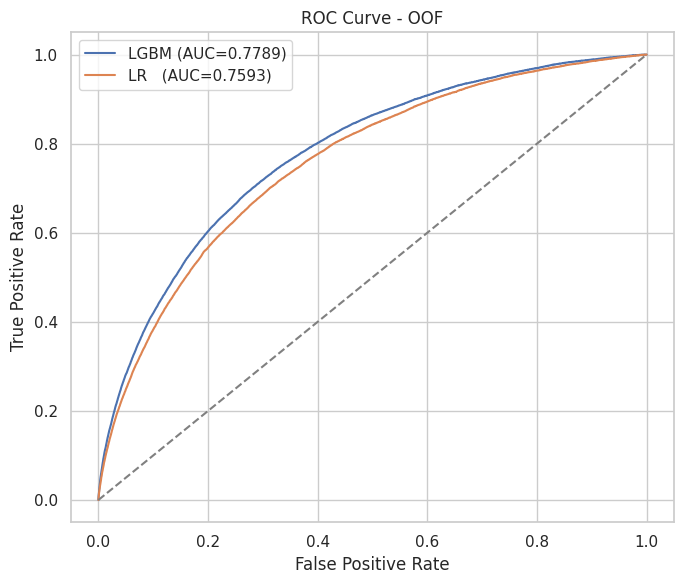

Saved plot: /content/drive/MyDrive/file/hasil/plots/pr_curve_oof.png


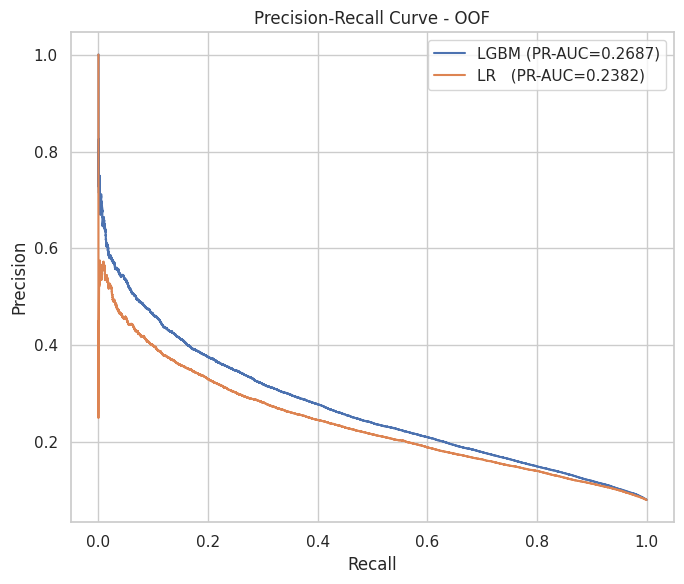

Saved plot: /content/drive/MyDrive/file/hasil/plots/lgbm_score_distribution_by_class.png


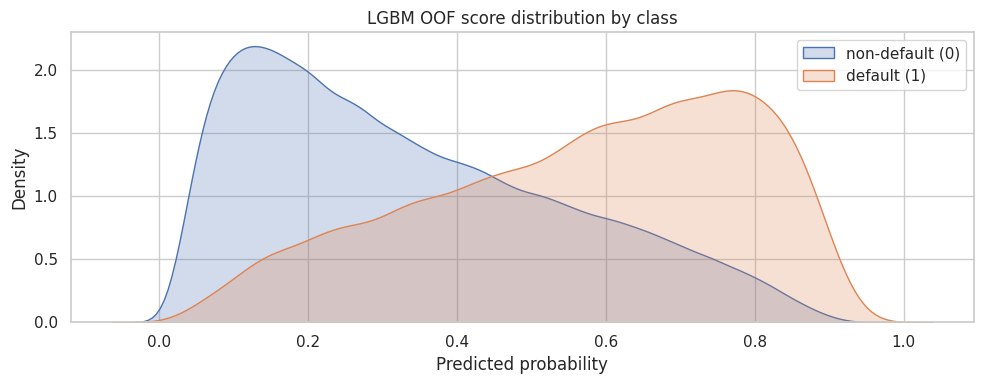

Saved plot: /content/drive/MyDrive/file/hasil/plots/lgbm_top40_feature_importance.png


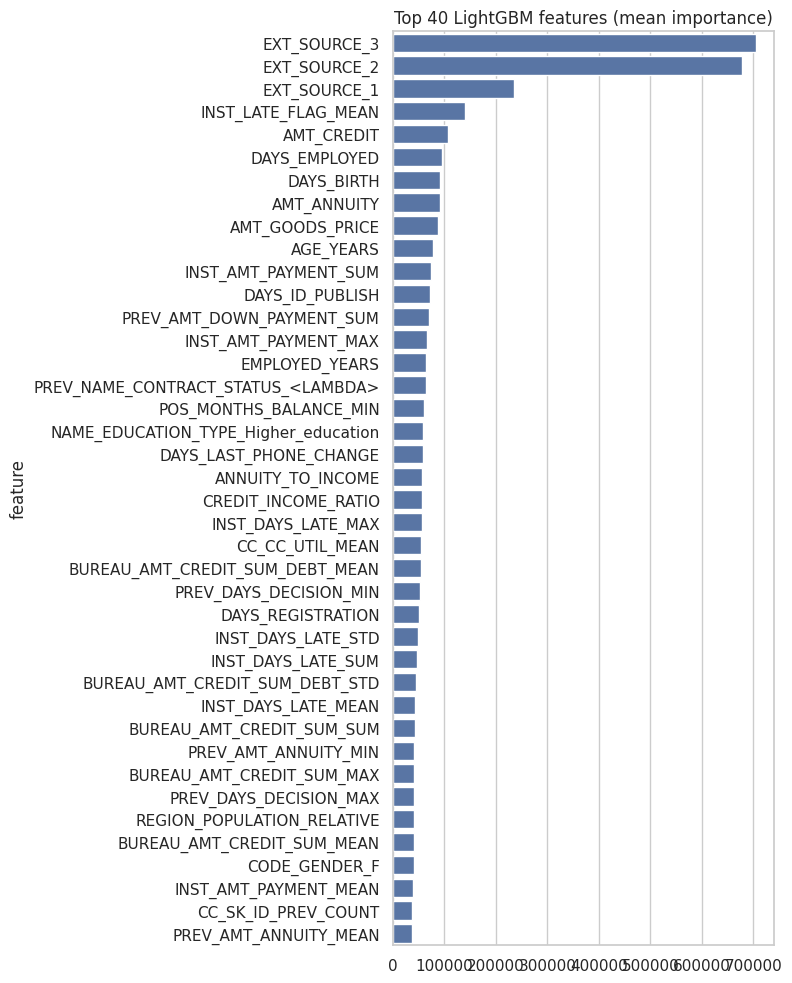

Saved plot: /content/drive/MyDrive/file/hasil/plots/lr_top30_coef_magnitude.png


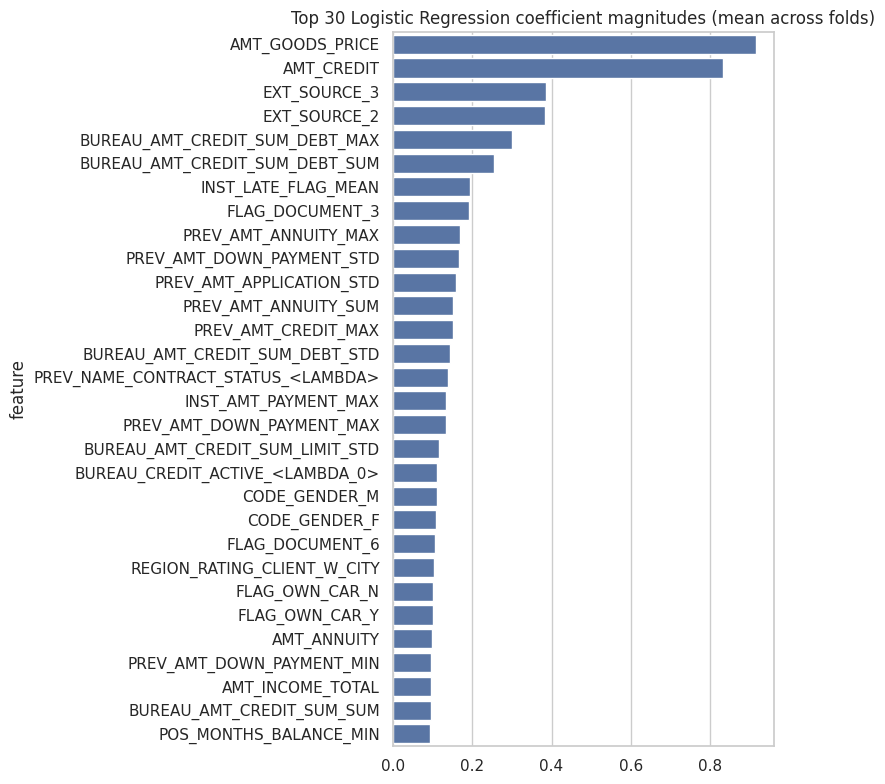

In [38]:
# MODEL VISUALS (paste this cell AFTER STEP 15 where oof_preds_lgb and oof_preds_lr exist)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve
sns.set(style='whitegrid')

# 1. ROC curve comparison (LGBM vs LR) using OOF preds
if 'oof_preds_lgb' in globals() and 'oof_preds_lr' in globals() and 'y' in globals():
    fpr_l, tpr_l, _ = roc_curve(y, oof_preds_lgb)
    fpr_lr, tpr_lr, _ = roc_curve(y, oof_preds_lr)
    auc_l = auc(fpr_l, tpr_l)
    auc_lr = auc(fpr_lr, tpr_lr)

    plt.figure(figsize=(7,6))
    plt.plot(fpr_l, tpr_l, label=f'LGBM (AUC={auc_l:.4f})')
    plt.plot(fpr_lr, tpr_lr, label=f'LR   (AUC={auc_lr:.4f})')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - OOF')
    plt.legend()
    plt.tight_layout()
    save_plot("roc_curve_oof", close_fig=False)
    plt.show()
    plt.close()
else:
    print('OOF predictions or y not found for ROC.')

# 2. Precision-Recall curves
if 'oof_preds_lgb' in globals() and 'oof_preds_lr' in globals() and 'y' in globals():
    p_l, r_l, _ = precision_recall_curve(y, oof_preds_lgb)
    p_lr, r_lr, _ = precision_recall_curve(y, oof_preds_lr)
    pr_auc_l = auc(r_l, p_l)
    pr_auc_lr = auc(r_lr, p_lr)

    plt.figure(figsize=(7,6))
    plt.plot(r_l, p_l, label=f'LGBM (PR-AUC={pr_auc_l:.4f})')
    plt.plot(r_lr, p_lr, label=f'LR   (PR-AUC={pr_auc_lr:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - OOF')
    plt.legend()
    plt.tight_layout()
    save_plot("pr_curve_oof", close_fig=False)
    plt.show()
    plt.close()

# 3. Predicted score distributions by class (LGBM)
if 'oof_preds_lgb' in globals() and 'y' in globals():
    plt.figure(figsize=(10,4))
    sns.kdeplot(oof_preds_lgb[y==0], label='non-default (0)', fill=True)
    sns.kdeplot(oof_preds_lgb[y==1], label='default (1)', fill=True)
    plt.title('LGBM OOF score distribution by class')
    plt.xlabel('Predicted probability')
    plt.legend()
    plt.tight_layout()
    save_plot("lgbm_score_distribution_by_class", close_fig=False)
    plt.show()
    plt.close()

# 4. Feature importance from LightGBM (mean across folds)
if 'fi' in globals():
    fi_agg = fi.groupby('feature')['importance'].mean().sort_values(ascending=False).head(40)
    plt.figure(figsize=(8,10))
    sns.barplot(x=fi_agg.values, y=fi_agg.index)
    plt.title('Top 40 LightGBM features (mean importance)')
    plt.tight_layout()
    save_plot("lgbm_top40_feature_importance", close_fig=False)
    plt.show()
    plt.close()
else:
    print('Feature importance (fi) not found.')

# 5. LR coefficient magnitudes (mean across folds)
if 'fi_lr' in globals():
    # fi_lr has columns ['feature','coef','fold']
    coef_agg = fi_lr.groupby('feature')['coef'].mean().abs().sort_values(ascending=False).head(30)
    plt.figure(figsize=(8,8))
    sns.barplot(x=coef_agg.values, y=coef_agg.index)
    plt.title('Top 30 Logistic Regression coefficient magnitudes (mean across folds)')
    plt.tight_layout()
    save_plot("lr_top30_coef_magnitude", close_fig=False)
    plt.show()
    plt.close()
else:
    print('LR coefficients (fi_lr) not found.')

# **STEP 16 - SHAP explainability (example on sample)**

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Saved plot: /content/drive/MyDrive/file/hasil/plots/shap_summary.png


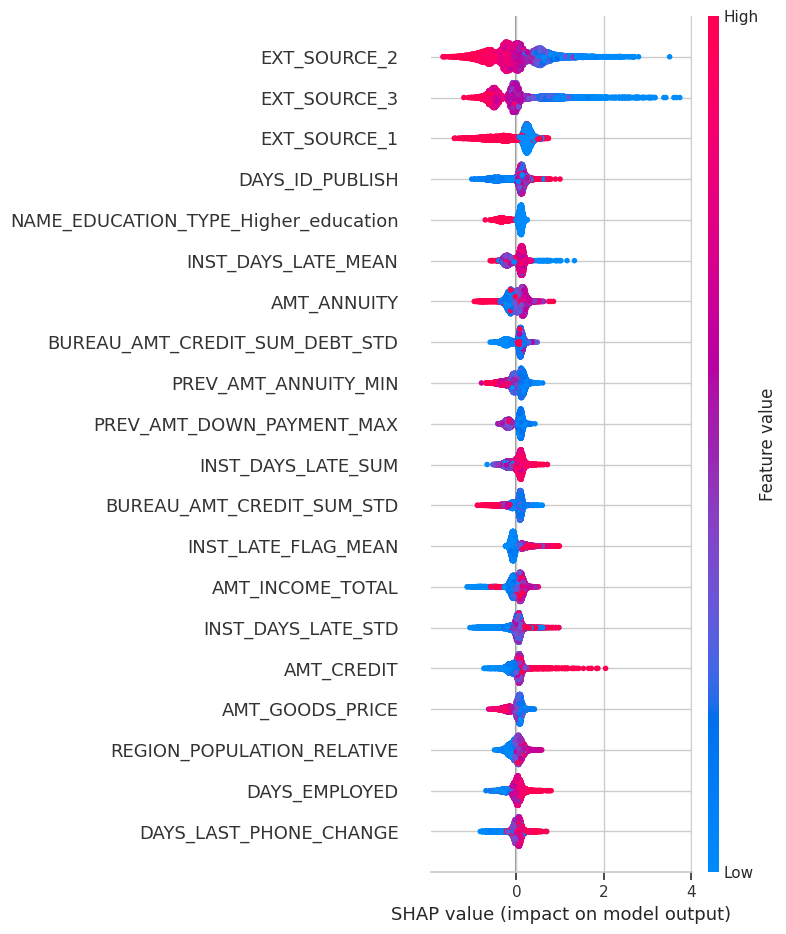

SHAP plots generated and saved as "shap_summary.png"


In [41]:
try:
    import shap
    import matplotlib.pyplot as plt

    # Load model from last fold if available
    # We will quickly fit a smaller model on all data for explanation when dataset is large
    if X.shape[0] > 10000:
        X_sample = X.sample(10000, random_state=RANDOM_STATE)
    else:
        X_sample = X.copy()

    # Train small model for SHAP explanation
    expl_model = lgb.LGBMClassifier(
        **{k: params[k] for k in ['learning_rate','num_leaves','max_depth','feature_fraction'] if k in params},
        n_estimators=1000,
        random_state=RANDOM_STATE
    )
    expl_model.fit(X_sample, y.loc[X_sample.index])

    expl = shap.TreeExplainer(expl_model)
    shap_vals = expl.shap_values(X_sample)

    # SHAP summary plot
    plt.figure(figsize=(10, 8))
    # Handle binary classification: shap_vals is a list of two arrays; we want class 1
    if isinstance(shap_vals, list):
        # Binary classification → use positive class (index 1)
        shap.summary_plot(shap_vals[1], X_sample, show=False)
    else:
        # Regression or already single array
        shap.summary_plot(shap_vals, X_sample, show=False)

    plt.tight_layout()
    save_plot("shap_summary", close_fig=False)
    plt.show()
    plt.close()
    print('SHAP plots generated and saved as "shap_summary.png"')

except Exception as e:
    print('SHAP failed or not installed:', e)

Saved plot: /content/drive/MyDrive/file/hasil/plots/shap_summary_top30.png


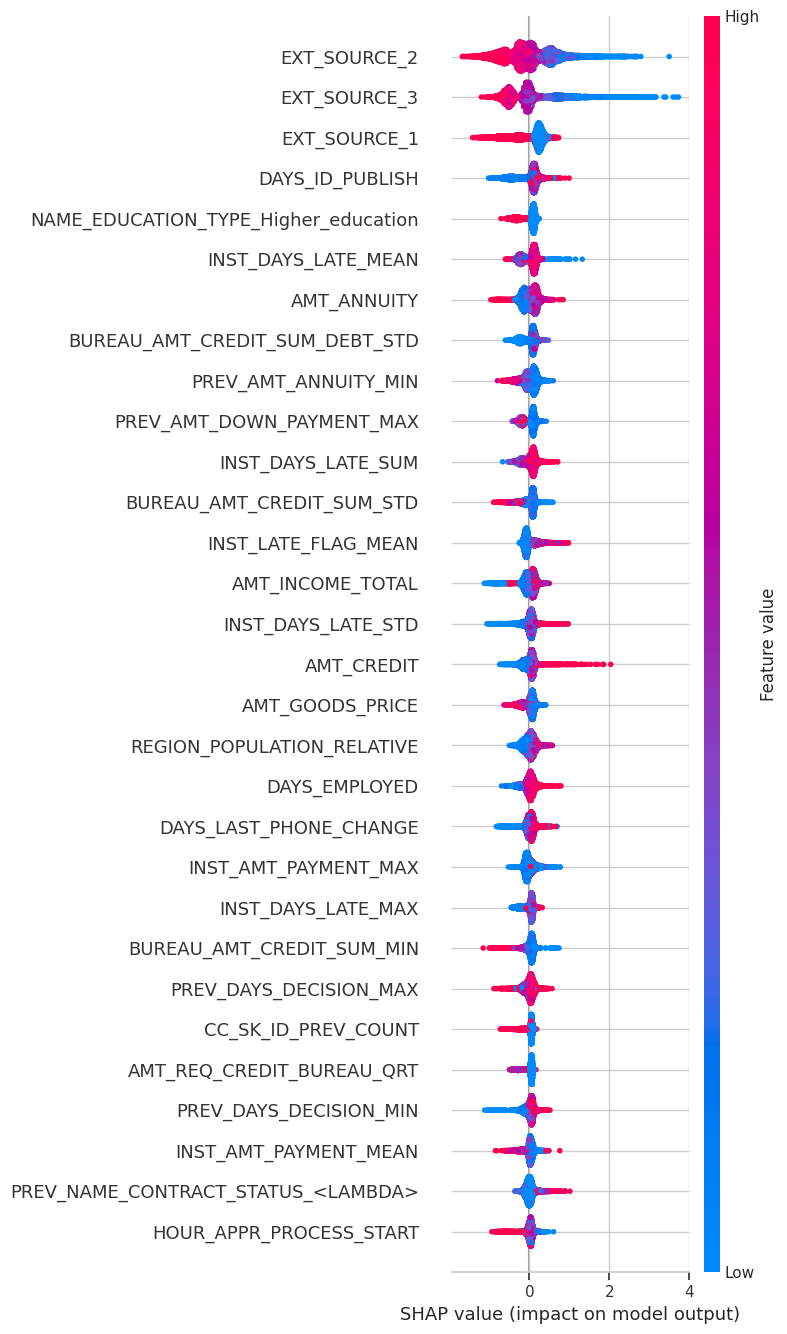

Saved plot: /content/drive/MyDrive/file/hasil/plots/shap_dependence_EXT_SOURCE_3.png


<Figure size 800x600 with 0 Axes>

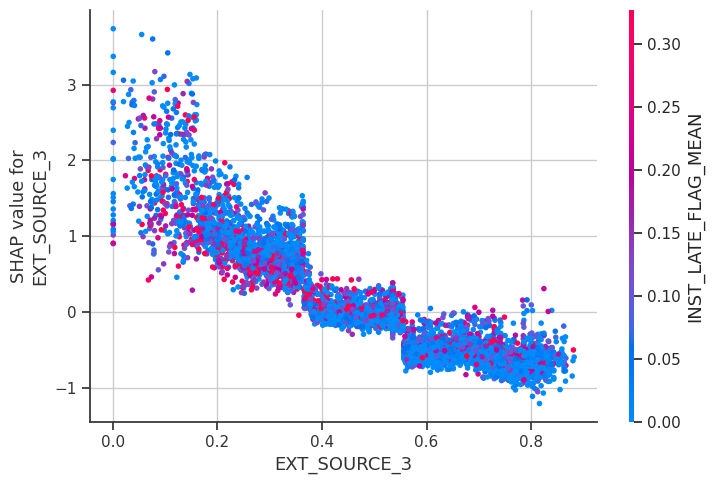

In [42]:
# SHAP summary & dependence (requires shap_vals from STEP 16)
try:
    import shap
    import matplotlib.pyplot as plt
    import pandas as pd

    if 'shap_vals' in globals() and 'X_sample' in globals():
        # --- 1. SHAP Summary Plot ---
        plt.figure(figsize=(10, 8))
        # Handle binary classification: shap_vals is a list → use class 1
        shap_input = shap_vals[1] if isinstance(shap_vals, list) else shap_vals
        shap.summary_plot(shap_input, X_sample, max_display=30, show=False)
        plt.tight_layout()
        save_plot("shap_summary_top30", close_fig=False)
        plt.show()
        plt.close()

        # --- 2. SHAP Dependence Plot (top feature) ---
        # Get top feature from LightGBM feature importance (fi)
        if 'fi' in globals():
            top_feat_df = pd.DataFrame({'imp': fi.groupby('feature')['importance'].mean()}).sort_values('imp', ascending=False).head(1)
            top_features = list(top_feat_df.index)
            if len(top_features) > 0:
                top_feat = top_features[0]
                if top_feat in X_sample.columns:
                    plt.figure(figsize=(8, 6))
                    shap.dependence_plot(top_feat, shap_input, X_sample, show=False)
                    plt.tight_layout()
                    save_plot(f"shap_dependence_{top_feat}", close_fig=False)
                    plt.show()
                    plt.close()
                else:
                    print(f"Top feature '{top_feat}' not in X_sample columns — skipping dependence plot.")
            else:
                print("No top feature found from 'fi' — skipping dependence plot.")
        else:
            print("'fi' (feature importance) not found — skipping dependence plot.")
    else:
        print("'shap_vals' or 'X_sample' not available — skipping SHAP plots.")

except Exception as e:
    print('SHAP plots skipped:', e)

# **STEP 17 - Save final model (retrain on full data and save)**


In [27]:
if X.shape[0] > 0:
    full_train = lgb.Dataset(X, label=y)
    final_params = params.copy()
    final_model = lgb.train(final_params, full_train, num_boost_round= int(np.mean([1000, 2000])))
    joblib.dump({'model': final_model, 'features': features}, OUT_DIR / 'final_model_v1.pkl')
    print('Final model retrained on full data and saved')



Final model retrained on full data and saved


# **STEP 18 - Scoring function (batch) and unit tests**



In [25]:
def score_applications(raw_app_df, agg_tables: dict, model_artifact_path=OUT_DIR / 'final_model_v1.pkl'):
    """
    raw_app_df: DataFrame like application_test.csv
    agg_tables: dict of precomputed aggregations keyed by name, produced same way as training pipeline
    The function should reproduce the same features list and return probabilities
    """
    # load model artifact
    artifact = joblib.load(model_artifact_path)
    model = artifact['model']
    features = artifact['features']
    # naive implementation: assume raw_app_df already has same columns
    X_sc = raw_app_df.copy()
    # ensure all feature columns exist
    for f in features:
        if f not in X_sc.columns:
            X_sc[f] = 0
    probs = model.predict(X_sc[features])
    return probs

# Unit test (sanity) for scoring if final model exists
if Path(OUT_DIR / 'final_model_v1.pkl').exists() and df_test.shape[0] > 0:
    try:
        probs = score_applications(df_test, {}, model_artifact_path=OUT_DIR / 'final_model_v1.pkl')
        print('Scoring test passed. Sample probs:', probs[:5])
    except Exception as e:
        print('Scoring test failed:', e)

Scoring test passed. Sample probs: [0.14901576 0.6068123  0.11028314 0.15351082 0.51530634]


# **STEP 19 - Monitoring stubs: PSI between training and test preds**

In [44]:
# === STEP 19 - Monitoring, Evaluation & Sample Scoring ===
import os
from sklearn.metrics import precision_recall_curve, auc, roc_curve

print("=== STEP 19: Final Evaluation & Monitoring ===")
print(f"Output directory: {OUT_DIR}")

# 1) List output files
print("\n--- Output Files ---")
out_files = list(OUT_DIR.glob('*'))
if out_files:
    for p in sorted(out_files):
        size = p.stat().st_size / 1024  # size in KB
        print(f'- {p.name} ({size:.1f} KB)')
else:
    print("No output files found")

# Helper function untuk load data
def safe_load(name, default=None):
    """Safely load pickle file with error handling"""
    p = OUT_DIR / name
    if p.exists():
        try:
            return joblib.load(p)
        except Exception as e:
            print(f"⚠️ Failed to load {p}: {e}")
    return default

# 2) Load predictions jika belum ada di memory
required_files = {
    'oof_preds_lgb.pkl': 'oof_preds_lgb',
    'test_preds_lgb.pkl': 'test_preds_lgb',
    'oof_preds_lr.pkl': 'oof_preds_lr',
    'test_preds_lr.pkl': 'test_preds_lr'
}

for file, var_name in required_files.items():
    if var_name not in globals() or globals()[var_name] is None:
        globals()[var_name] = safe_load(file)

# 3) Calculate and display metrics sekali saja
print("\n--- Model Performance Summary ---")

def calculate_metrics(y_true, preds, model_name):
    """Calculate all metrics for a model"""
    if preds is None or y_true is None:
        return None

    try:
        # ROC AUC
        roc_auc = roc_auc_score(y_true, preds)

        # Precision-Recall AUC
        precision, recall, _ = precision_recall_curve(y_true, preds)
        pr_auc = auc(recall, precision)

        return {'roc_auc': roc_auc, 'pr_auc': pr_auc}
    except Exception as e:
        print(f"Error calculating metrics for {model_name}: {e}")
        return None

# Calculate metrics untuk semua model
metrics = {}
for model_name in ['LGBM', 'LR']:
    oof_preds = globals().get(f'oof_preds_{model_name.lower()}')
    metrics[model_name] = calculate_metrics(y, oof_preds, model_name)

# Display results
for model_name, model_metrics in metrics.items():
    if model_metrics:
        print(f"{model_name:4} | ROC-AUC: {model_metrics['roc_auc']:.6f} | PR-AUC: {model_metrics['pr_auc']:.6f}")

# 4) PSI Calculation (sekali saja untuk kedua model)
print("\n--- Distribution Stability (PSI) ---")
for model_name in ['LGBM', 'LR']:
    oof_key = f'oof_preds_{model_name.lower()}'
    test_key = f'test_preds_{model_name.lower()}'

    oof_preds = globals().get(oof_key)
    test_preds = globals().get(test_key)

    if oof_preds is not None and test_preds is not None:
        try:
            psi_val = psi(oof_preds, test_preds)
            interpretation = "Good" if psi_val < 0.1 else "Moderate" if psi_val < 0.2 else "High drift"
            print(f"{model_name:4} | PSI: {psi_val:.6f} ({interpretation})")
        except Exception as e:
            print(f"{model_name:4} | PSI calculation failed: {e}")
    else:
        print(f"{model_name:4} | PSI: Not available")

# 5) Sample Scoring dengan model final
print("\n--- Sample Scoring ---")
final_model_path = OUT_DIR / 'final_model_v1.pkl'

if final_model_path.exists():
    try:
        artifact = joblib.load(final_model_path)
        model = artifact.get('model')
        feat_list = artifact.get('features', [])

        print(f"✓ Final model loaded: {len(feat_list)} features")

        if df_test.shape[0] > 0:
            # Sample scoring
            sample_test = df_test.head(3).copy()

            # Ensure feature columns exist
            for f in feat_list:
                if f not in sample_test.columns:
                    sample_test[f] = 0

            probs = model.predict(sample_test[feat_list])

            print("Sample predictions (first 3 applications):")
            for i, prob in enumerate(probs):
                risk_level = "HIGH RISK" if prob > 0.5 else "LOW RISK"
                print(f"  App {i+1}: {prob:.4f} → {risk_level}")

            # Ensemble scoring jika kedua model tersedia
            if (test_preds_lgb is not None and test_preds_lr is not None and
                len(test_preds_lgb) >= 3 and len(test_preds_lr) >= 3):
                ensemble_probs = (test_preds_lgb[:3] + test_preds_lr[:3]) / 2.0
                print("\nEnsemble predictions (LGBM + LR average):")
                for i, prob in enumerate(ensemble_probs):
                    risk_level = "HIGH RISK" if prob > 0.5 else "LOW RISK"
                    print(f"  App {i+1}: {prob:.4f} → {risk_level}")

        else:
            print("✗ No test data available for sample scoring")

    except Exception as e:
        print(f"✗ Failed to load final model: {e}")
else:
    print("✗ Final model not found - run STEP 17 first")

# 6) Quick health check
print("\n--- Data Health Check ---")
print(f"Training data: {X.shape if 'X' in globals() else 'Not available'}")
print(f"Test data: {X_test.shape if 'X_test' in globals() else 'Not available'}")
print(f"Target distribution: {y.value_counts().to_dict() if 'y' in globals() else 'Not available'}")

# 7) Load feature importance jika ada
print("\n--- Feature Analysis ---")
fi_files = {
    'feature_importance_lgb.csv': 'LightGBM',
    'feature_importance_lr.csv': 'Logistic Regression'
}

for file, model_name in fi_files.items():
    fi_path = OUT_DIR / file
    if fi_path.exists():
        try:
            fi_df = pd.read_csv(fi_path)
            top_features = fi_df.groupby('feature')['importance' if 'lgb' in file else 'coef'].mean().abs().sort_values(ascending=False).head(3)
            print(f"{model_name:20} | Top 3: {', '.join(top_features.index[:3])}")
        except Exception as e:
            print(f"{model_name:20} | Error loading: {e}")
    else:
        print(f"{model_name:20} | Feature importance not available")

print("\n=== STEP 19 completed ===")

=== STEP 19: Final Evaluation & Monitoring ===
Output directory: /content/drive/MyDrive/file/hasil

--- Output Files ---
- .ipynb_checkpoints (4.0 KB)
- feature_importance_lgb.csv (51.4 KB)
- feature_importance_lr.csv (56.7 KB)
- features_list.pkl (6.2 KB)
- final_model_v1.pkl (10496.8 KB)
- oof_preds_lgb.pkl (2402.7 KB)
- oof_preds_lr.pkl (2402.7 KB)
- plots (4.0 KB)
- test_preds_lgb.pkl (381.0 KB)
- test_preds_lr.pkl (381.0 KB)

--- Model Performance Summary ---
LR   | ROC-AUC: 0.759288 | PR-AUC: 0.238175

--- Distribution Stability (PSI) ---
LGBM | PSI: Not available
LR   | PSI: 0.002842 (Good)

--- Sample Scoring ---
✓ Final model loaded: 256 features
Sample predictions (first 3 applications):
  App 1: 0.1490 → LOW RISK
  App 2: 0.6068 → HIGH RISK
  App 3: 0.1103 → LOW RISK

Ensemble predictions (LGBM + LR average):
  App 1: 0.3310 → LOW RISK
  App 2: 0.6674 → HIGH RISK
  App 3: 0.1474 → LOW RISK

--- Data Health Check ---
Training data: (307511, 256)
Test data: (48744, 256)
Target